In [25]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2
# import albumentations as A
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import numpy as np
from segmentation_models_pytorch import Unet
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [26]:
id_to_label = {0: 'Basophil', 1: 'Eosinophil', 2: 'Lymphocyte', 3: 'Monocyte', 4: 'Neutrophil'}
label_to_id = {'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}

class TrainDataset(Dataset):
    def __init__(self, root_dir, mask_dir, transform=None):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        for subdir in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, subdir)):
                for filename in os.listdir(os.path.join(root_dir, subdir)):
                    if filename.endswith(".jpg"):
                        image_path = os.path.join(root_dir, subdir, filename)
                        mask_path = os.path.join(mask_dir, subdir, filename)
                        if os.path.exists(mask_path):
                            self.image_paths.append(image_path)
                            self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB") 
        mask = Image.open(mask_path).convert("L")

        seed = torch.randint(2147483647, (1,)).item()
        torch.manual_seed(seed)
        image = common_transform(image)
        torch.manual_seed(seed)
        mask = common_transform(mask)
        image = color_transform(image)
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        image = torch.cat((image, mask), dim=0)
        image = self.transform(image)
        
        label = os.path.basename(os.path.dirname(img_path))
        label = label_to_id[label]
        return image, label


    
class TestDataset(Dataset):
    def __init__(self, root_dir, mask_dir, transform=None):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        for subdir in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, subdir)):
                for filename in os.listdir(os.path.join(root_dir, subdir)):
                    if filename.endswith(".jpg"):
                        image_path = os.path.join(root_dir, subdir, filename)
                        mask_path = os.path.join(mask_dir, subdir, filename)
                        if not os.path.exists(mask_path):
                            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        image = Image.open(img_path).convert("RGB") 

        image = transforms.ToTensor()(image)
        image = self.transform(image)
        filename = os.path.basename(img_path)
        
        label = os.path.basename(os.path.dirname(img_path))
        label = label_to_id[label]
        return image, label, filename

# Constant values

In [27]:
WBC_1_train_dir = 'WBC_1/train/data'
WBC_1_train_mask_dir = 'WBC_1/train/mask'
WBC_1_train_pred_mask_dir = 'WBC_1/train/pred_mask'
WBC_10_train_dir = 'WBC_10/train/data'
WBC_10_train_mask_dir = 'WBC_10/train/mask'
WBC_10_train_pred_mask_dir = 'WBC_10/train/pred_mask'
WBC_50_train_dir = 'WBC_50/train/data'
WBC_50_train_mask_dir = 'WBC_50/train/mask'
WBC_50_train_pred_mask_dir = 'WBC_50/train/pred_mask'
WBC_100_train_dir = 'WBC_100/train/data'
WBC_100_train_mask_dir = 'WBC_100/train/mask'
WBC_100_train_pred_mask_dir = 'WBC_100/train/pred_mask'
WBC_100_val_dir = 'WBC_100/val/data'
CAM16_100_train_dir = 'CAM16_100cls_10mask/train/data'
CAM16_100_train_mask_dir = 'CAM16_100cls_10mask/train/mask'
CAM16_100_val_dir = 'CAM16_100cls_10mask/val/data'
CAM16_100_test_dir = 'CAM16_100cls_10mask/test/data'

proportion = 100
WBC_train_dir = 'WBC_' + str(proportion) + '/train/data'
WBC_mask_dir = 'WBC_' + str(proportion) + '/train/mask'
WBC_pred_mask_dir ='WBC_' + str(proportion) + '/train/pred_mask'

model_load_path = "UNet_CAM16_model.pth"
# model_save_path = "CustomLoss_UNet_WBC" + str(proportion) +"_model.pth" 
model_save_path = "CustomLoss_UNet_WBC" + str(proportion) +"_model.pth" 

resize = 224

train_transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.Normalize([0.485, 0.456, 0.406, 0.0], [0.229, 0.224, 0.225, 1.0])
])

test_transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

common_transform = transforms.Compose([
transforms.RandomRotation(360),
transforms.RandomResizedCrop(resize),
])

color_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

train_dataset = TrainDataset(WBC_train_dir, WBC_mask_dir, train_transform)
test_dataset = TestDataset(WBC_train_dir, WBC_mask_dir, test_transform)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# for images, labels in data_loader:

#     for i in range(len(images)):
#         image = images[i, :3] 
#         mask = images[i, 3] 
#         label = labels[i]
#         print(f"Label: {label.item()}")

#         plt.imshow(image.permute(1, 2, 0))
#         plt.title("Original Image")
#         plt.show()

#         plt.imshow(mask, cmap='gray')
#         plt.title("Mask")
#         plt.show()

In [28]:
class CustomLoss(nn.Module):
    def __init__(self, image_size, device):
        super(CustomLoss, self).__init__()
        self.image_size = image_size
        self.center = self.image_size // 2
        self.device = device

    def forward(self, pred, target):
        x = torch.arange(self.image_size).float().unsqueeze(0).repeat(self.image_size, 1).to(self.device)
        y = torch.arange(self.image_size).float().unsqueeze(1).repeat(1, self.image_size).to(self.device)
        l2_distance = torch.sqrt((x - self.center) ** 2 + (y - self.center) ** 2)

        weight = l2_distance
        loss = F.binary_cross_entropy(pred, target, weight=weight)

        return loss.mean()

Epoch 1, Loss: 18.85147928741743
Misclassified Pixels: 5401759 / 42248192 (12.79%)
Epoch 2, Loss: 11.550530825021132
Misclassified Pixels: 3582839 / 42248192 (8.48%)
Epoch 3, Loss: 9.073079442078212
Misclassified Pixels: 3092083 / 42248192 (7.32%)
Epoch 4, Loss: 7.8256872779918165
Misclassified Pixels: 2825443 / 42248192 (6.69%)
Epoch 5, Loss: 7.966817480213237
Misclassified Pixels: 2820827 / 42248192 (6.68%)
Epoch 6, Loss: 6.869460638963951
Misclassified Pixels: 2617648 / 42248192 (6.20%)
Epoch 7, Loss: 6.92904018231158
Misclassified Pixels: 2667005 / 42248192 (6.31%)
Epoch 8, Loss: 6.581770555028376
Misclassified Pixels: 2568292 / 42248192 (6.08%)
Epoch 9, Loss: 6.038890269567382
Misclassified Pixels: 2481754 / 42248192 (5.87%)
Epoch 10, Loss: 6.463530011896817
Misclassified Pixels: 2536965 / 42248192 (6.00%)


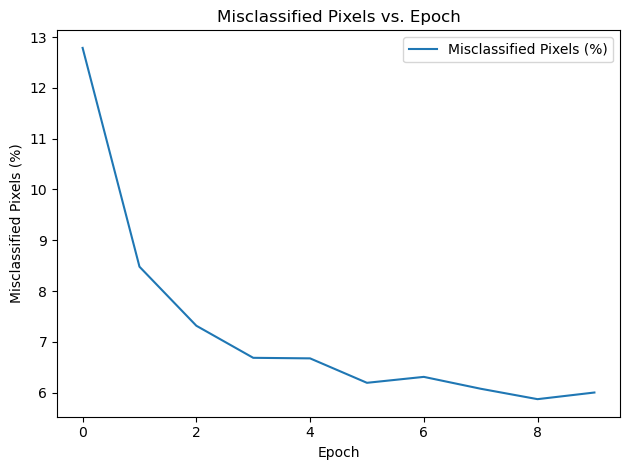

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet('resnet34', in_channels=3, classes=1).to(device)

# if model_load_path != "":
#     model.load_state_dict(torch.load(model_load_path))

height, width = resize, resize

# criterion = nn.BCELoss()
criterion = CustomLoss(resize, device)


num_epochs = int(1000 / proportion)


opt = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)
sch = optim.lr_scheduler.StepLR(opt, max(1, int(num_epochs/5)), 0.5)

losses = []
misclassified_pixels_list = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    misclassified_pixels = 0

    for inputs, _ in train_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs[:, 0:3])
        output_probabilities = torch.sigmoid(outputs)
        loss = criterion(output_probabilities.squeeze(1), inputs[:, 3])
#         loss = torch.mean(loss * weight_mask.to(device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += loss.item()
        predicted_mask = (output_probabilities > 0.5)
        misclassified_pixels += torch.sum(predicted_mask.squeeze(1) != inputs[:, 3]).item()
    
    sch.step()   
    total_pixels = len(train_dataloader.dataset) * resize * resize

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}")
    print(f"Misclassified Pixels: {misclassified_pixels} / {total_pixels} ({misclassified_pixels / total_pixels * 100:.2f}%)")
    
    losses.append(running_loss / len(train_dataloader))
    misclassified_pixels_list.append(misclassified_pixels / total_pixels * 100)

torch.save(model.state_dict(), model_save_path)

plt.plot(range(num_epochs), misclassified_pixels_list, label='Misclassified Pixels (%)')
plt.xlabel('Epoch')
plt.ylabel('Misclassified Pixels (%)')
plt.title('Misclassified Pixels vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

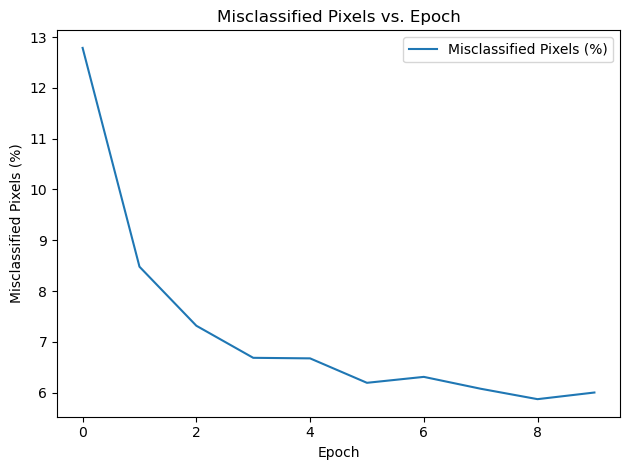

In [30]:
plt.plot(range(num_epochs), misclassified_pixels_list, label='Misclassified Pixels (%)')
plt.xlabel('Epoch')
plt.ylabel('Misclassified Pixels (%)')
plt.title('Misclassified Pixels vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, _ in train_dataloader:
        for X in inputs:
            X = X.to(device)
            pred = model(X[0:3].unsqueeze(0))
            pred_probability = torch.sigmoid(pred)
            pred_mask = (pred_probability > 0.5)
            pred_mask = pred_mask.cpu().numpy()
            X = X.cpu().numpy()
            fig, axes = plt.subplots(1, 3, figsize=(10, 5))
            
            axes[0].imshow(X[0:3].transpose(1, 2, 0))
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(X[3], cmap='gray')
            axes[1].set_title('Original Mask')
            axes[1].axis('off')
            
            axes[2].imshow(pred_mask[0, 0], cmap='gray')
            axes[2].set_title('Predicted mask')
            axes[2].axis('off')

            plt.show()


# Generate Mask To Disk

In [32]:
# model.eval()
# with torch.no_grad():
#     for inputs, labels, names in test_dataloader:
#         for X, label, name in zip(inputs, labels, names):
#             X = X.to(device)
#             pred = model(X.unsqueeze(0))
#             pred_probability = torch.sigmoid(pred)
#             pred_mask = (pred_probability > 0.5)
#             pred_mask = pred_mask.cpu().numpy()
#             X = X.cpu().numpy()

# #             fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# #             axes[0].imshow(X.transpose(1, 2, 0))
# #             axes[0].set_title('Original Image')
# #             axes[0].axis('off')
# #             axes[1].imshow(pred_mask[0, 0], cmap='gray')
# #             axes[1].set_title('Predicted mask')
# #             axes[1].axis('off')
# #             plt.show()
            
            
#             if not os.path.exists(WBC_pred_mask_dir):
#                 os.makedirs(WBC_pred_mask_dir)
            
#             label_folder = id_to_label[int(label)]
            
#             target_folder = os.path.join(WBC_pred_mask_dir, label_folder)
            
#             if not os.path.exists(target_folder):
#                 os.makedirs(target_folder)

#             save_path = os.path.join(target_folder, name)
#             pred_mask_image = Image.fromarray((pred_mask[0, 0] * 255).astype('uint8'), mode='L')
#             pred_mask_image.save(save_path)
